In [1]:
!git clone https://github.com/liuzhimei/M2_coursework.git
%cd M2_coursework
!pwd

fatal: destination path 'M2_coursework' already exists and is not an empty directory.
/content/M2_coursework
/content/M2_coursework


In [2]:
!nvidia-smi

Mon Mar 24 23:39:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
!nvidia-smi --gpu-reset

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.


In [3]:
import torch
import h5py
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from accelerate import Accelerator
from torch.utils.data import DataLoader, TensorDataset
from src.qwen import load_qwen
from src.preprocessor import preprocess_time_series, preprocess_all_time_series, tokenize_sequence
from lora.lora_skeleton import LoRALinear, process_sequences

torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# LoRA

In [4]:
with h5py.File("data/lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

In [5]:
model, tokenizer = load_qwen()
lora_rank = 4

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)
# ^These are the parts that will actually be trained!

# Process the data into sequences of text
train_texts, val_texts, test_texts = preprocess_all_time_series(trajectories)

# ^Each of these is a `list[str]` representing contiguous parts of the time series,
#  in text form (using the LLMTIME scheme).

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


## Model training

In [6]:
# Defines the maximum context length
max_ctx_length = 512

train_input_ids = process_sequences(
    train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
)
val_input_ids = process_sequences(
    val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
)

train_input_ids = torch.tensor(train_input_ids)
val_input_ids = torch.tensor(val_input_ids)

batch_size = 4
learning_rate = 1e-5

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=learning_rate
)

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

accelerator = Accelerator()
model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

<ipython-input-6-8e56767f77a3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input_ids = torch.tensor(train_input_ids)
<ipython-input-6-8e56767f77a3>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_input_ids = torch.tensor(val_input_ids)


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.08it/s]


Step 998 | Train Loss: 0.3464 | Val Loss: 0.2142


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.09it/s]


Step 1996 | Train Loss: 0.2204 | Val Loss: 0.1976


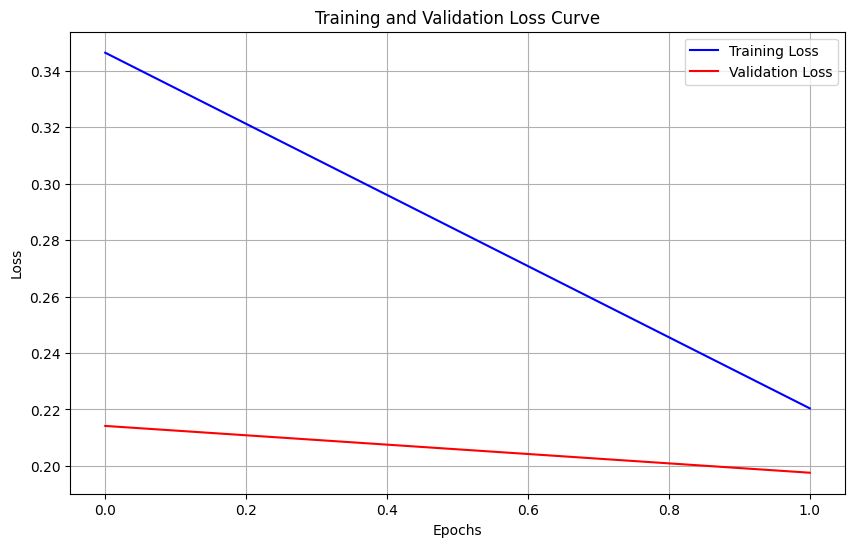

In [8]:
# Initialize lists to track losses
train_losses = []
val_losses = []

model.train()
epochs = 2
max_steps = 1000
steps = 0

# Training loop
for epoch in range(epochs):
    total_train_loss = 0
    num_batches_train = 0

    progress_bar_train = tqdm(train_loader, desc="Training")
    for (batch,) in progress_bar_train:
        torch.cuda.empty_cache()

        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss
        accelerator.backward(loss) # with accelerator, batch is already on correct device
        optimizer.step()

        # Track loss
        total_train_loss += loss.item()
        num_batches_train += 1
        steps += 1

        # # After every batch or a set number of steps, append the training loss
        # train_losses.append(total_train_loss / num_batches_train)

        # # progress_bar_train.set_postfix(loss=loss.item())
        # if steps > max_steps:
        #     break

    train_losses.append(total_train_loss / len(train_loader.dataset))


    model.eval()
    total_val_loss = 0
    num_batches_val = 0
    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc="Validating")
        for (batch,) in progress_bar_val:
            torch.cuda.empty_cache()

            outputs = model(batch, labels=batch)
            loss = outputs.loss

            total_val_loss += loss.item()
            num_batches_val += 1

    # avg_val_loss = total_val_loss / num_batches_val
    val_losses.append(total_val_loss / len(val_loader.dataset))

    # Print current training and validation loss
    print(f"Step {steps} | Train Loss: {total_train_loss / len(train_loader.dataset):.4f} | Val Loss: {total_val_loss / len(val_loader.dataset):.4f}")
    model.train()

# Plotting the loss curves after training is done
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Training Loss", color='blue')
plt.plot(range(epochs), val_losses, label="Validation Loss", color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Make prediction

In [13]:
def decode_time_series(generated_text, alpha=0.5, max_time_steps=20):
    """
    Decodes a generated time-series string of texts back into numerical data.

    Args:
        generated_text (str): Preprocessed string in LLMTIME format. e.g. ;6.398,1.204;6.676,1.310;6.891,1.446
        alpha (float): Scaling factor used during preprocessing (default is 0.5).
        max_time_steps (int): Maximum number of time steps to decode (default is 20).

    Returns:
        np.ndarray: Decoded time-series data of shape (T, 2).
    """
    # Remove leading semicolon if it exists
    generated_text = generated_text.lstrip(";")

    # Split the string into time steps and filter out any empty strings
    time_steps = [step for step in generated_text.split(";") if step]

    # Convert each pair of values back to float and reverse scaling
    data = []
    for i, step in enumerate(time_steps):
        if i >= max_time_steps:  # Stop after decoding max_time_steps
            break

        # Check if the step is in the correct format (i.e., contains exactly two values separated by a comma)
        if len(step.split(",")) == 2:
            try:
                prey, predator = map(float, step.split(","))
                data.append([prey * alpha, predator * alpha])
            except ValueError:
                print(f"Skipping invalid data (non-float values): {step}")
        else:
            print(f"Skipping malformed data: {step}")

    return np.array(data, dtype=np.float32)

decode_time_series(';6.398,1.204;6.676,1.310;6.891,1.446') # check the function

array([[3.199 , 0.602 ],
       [3.338 , 0.655 ],
       [3.4455, 0.723 ]], dtype=float32)

System:   0%|          | 0/1 [00:00<?, ?it/s]

generated tokens: [26, 20, 13, 15, 15, 21, 11, 15, 13, 23, 19, 17, 26, 19, 13, 24, 21, 18, 11, 15, 13, 23, 23, 19, 26, 19, 13, 21, 17, 24, 11, 15, 13, 24, 17, 22, 26, 19, 13, 16, 19, 23, 11, 16, 13, 15, 17, 22, 26, 18, 13, 20, 23, 21, 11, 16, 13, 16, 18, 23, 26, 18, 13, 19, 21, 22, 11, 16, 13, 18, 18, 23, 26, 18, 13, 19, 21, 20, 11, 16, 13, 20, 18, 15, 26, 18, 13, 20, 18, 17, 11, 16, 13, 22, 18, 17, 26, 18, 13, 24, 23, 22, 11, 16, 13, 23, 24, 15, 26, 19, 13, 17, 24, 15, 11, 16, 13, 24, 24, 20, 26, 20, 13, 15, 15, 21, 11, 17, 13, 15, 18, 20, 26, 20, 13, 18, 18, 21, 11, 17, 13, 16, 15, 21, 26, 20, 13, 20, 18, 20, 11, 17, 13, 15, 20, 20, 26, 20, 13, 18, 18, 16, 11, 16, 13, 24, 17, 15, 26, 19, 13, 23, 18, 21, 11, 16, 13, 23, 20, 15, 26, 19, 13, 20, 15, 15, 11, 16, 13, 22, 19, 19, 26, 19, 13, 16, 21, 16, 11, 16, 13, 21, 20, 19, 26, 18, 13, 23, 23, 21, 11, 16, 13, 20, 24, 16, 26, 18, 13, 21, 18, 17, 11, 16, 13, 20, 18, 17, 26, 18, 13, 20, 17, 21, 11, 16, 13, 19, 23, 24, 26, 18, 13, 21, 16, 2

System: 100%|██████████| 1/1 [02:09<00:00, 129.40s/it]

generated tokens: [26, 20, 13, 15, 21, 24, 11, 15, 13, 24, 15, 19, 26, 20, 13, 18, 23, 17, 11, 15, 13, 24, 21, 20, 26, 20, 13, 18, 19, 23, 11, 16, 13, 15, 21, 21, 26, 20, 13, 16, 20, 15, 11, 16, 13, 16, 22, 22, 26, 19, 13, 21, 22, 20, 11, 16, 13, 18, 15, 17, 26, 19, 13, 17, 19, 20, 11, 16, 13, 18, 24, 22, 26, 18, 13, 22, 24, 20, 11, 16, 13, 19, 24, 17, 26, 18, 13, 19, 20, 18, 11, 16, 13, 20, 24, 21, 26, 18, 13, 18, 16, 20, 11, 16, 13, 21, 18, 21, 26, 18, 13, 19, 21, 18, 11, 16, 13, 21, 21, 17, 26, 18, 13, 21, 20, 21, 11, 16, 13, 21, 20, 18, 26, 18, 13, 24, 22, 22, 11, 16, 13, 21, 19, 23, 26, 19, 13, 18, 23, 16, 11, 16, 13, 21, 20, 23, 26, 19, 13, 20, 16, 18, 11, 16, 13, 21, 18, 21, 26, 19, 13, 22, 15, 24, 11, 16, 13, 21, 17, 20, 26, 20, 13, 15, 15, 22, 11, 16, 13, 21, 16, 15, 26, 20, 13, 16, 16, 24, 11, 16, 13, 21, 20, 22, 26, 20, 13, 16, 24, 22, 11, 16, 13, 22, 15, 16, 26, 20, 13, 18, 15, 21, 11, 16, 13, 22, 23, 20, 26, 20, 13, 17, 20, 21, 11, 16, 13, 24, 17, 22, 26, 20, 13, 16, 22, 1

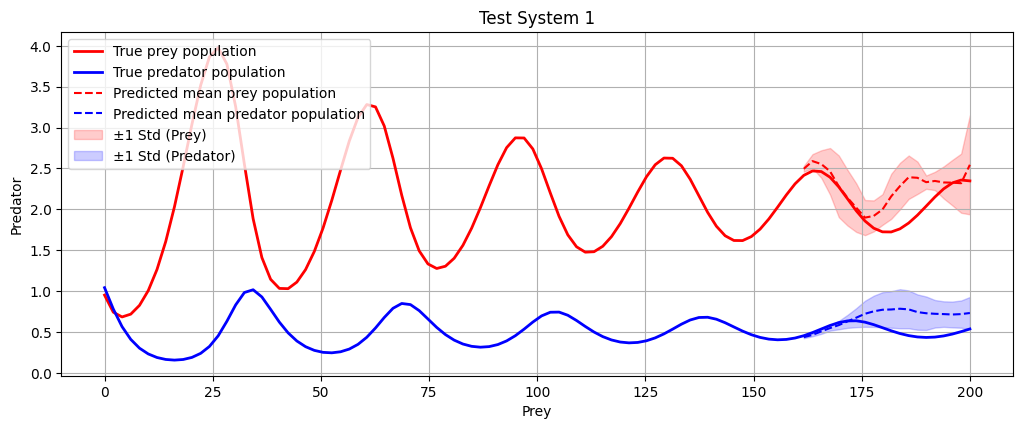

In [16]:
def plot_predictions(model, test_texts, accelerator, tokenizer, decimals=3):
    plt.figure(figsize=(20, 12))

    device = accelerator.device

    for system_id in tqdm(range(1), desc="System"):
        prey = trajectories[system_id, :, 0] # a list of 100 points for population of prey
        predator = trajectories[system_id, :, 1] # a list of 100 points for population of predator

        raw_data = np.column_stack((prey[:80], predator[:80])) # only stack the first 80 time steps (shape: (80,2))

        preprocessed_text = preprocess_time_series(raw_data) # apply LLMTIME scheme to convert raw data to texts

        tokenized_input = tokenize_sequence(preprocessed_text)  # use Qwen2.5 to tokenize the text (looks like [17, 13, ...])

        # Generate predictions (repeat for stochastic models to get variance)
        num_samples = 3  # Number of samples to estimate uncertainty
        num_tokens = 500 # predict 20 time steps need 240 tokens (for decimal=3)
        preds = []

        for _ in range(num_samples):
            input_tensor = torch.tensor(tokenized_input, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

            # Autoregressive prediction for next num_token number of tokens
            generated_tokens = []
            for _ in range(num_tokens):
                with torch.no_grad():
                    output = model(input_tensor)
                    # next_token = output.logits[:, -1, :].argmax(dim=-1).unsqueeze(0)  # Get most likely next token

                    # Define temperature for randomness (variability) to the autoregressive predictions
                    temperature = 1.0  # You can experiment with higher values (1.0) or lower (0.5) for more randomness
                    logits = output.logits[:, -1, :] / temperature  # Adjust logits with temperature
                    probs = torch.nn.functional.softmax(logits, dim=-1)
                    next_token = torch.multinomial(probs, 1)  # Sample from the distribution

                    generated_tokens.append(next_token.item())

                    # Append predicted token to input for next step
                    input_tensor = torch.cat([input_tensor, next_token], dim=1) # final form: tensor([[17, 18, 13, ...]])

            # Decode generated tokens back to time series data
            print(f"generated tokens: {generated_tokens}")
            generated_text = tokenizer.decode(generated_tokens)
            print(f"generated text: {generated_text}")

            generated_series = decode_time_series(generated_text)  # Convert texts back to numerical series and truncate the series at 100 time step
            # print(f"generated time series: {generated_series}")

            preds.append(generated_series)

        preds = np.array(preds)  # Shape: (num_samples, T=20, 2)
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0)

        # Plot true series
        plt.subplot(3, 2, system_id + 1)
        plt.plot(time_points, prey, label=f'True prey population', color='red', linewidth=2)
        plt.plot(time_points, predator, label=f'True predator population', color='blue', linewidth=2)

        # Plot predicted mean with dashed line
        plt.plot(time_points[80:], mean_pred[:, 0], label='Predicted mean prey population', color='red', linestyle='--')
        plt.plot(time_points[80:], mean_pred[:, 1], label='Predicted mean predator population', color='blue', linestyle='--')

        # Plot shaded area for 1 standard deviation
        plt.fill_between(time_points[80:],
                        mean_pred[:, 0] - std_pred[:, 0],
                        mean_pred[:, 0] + std_pred[:, 0],
                        color='red', alpha=0.2, label='±1 Std (Prey)')

        plt.fill_between(time_points[80:],
                 mean_pred[:, 1] - std_pred[:, 1],
                 mean_pred[:, 1] + std_pred[:, 1],
                 color='blue', alpha=0.2, label='±1 Std (Predator)')


        plt.title(f'System {system_id + 1}')
        plt.xlabel('Prey')
        plt.ylabel('Predator')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function after training with tokenization
accelerator = Accelerator()
plot_predictions(model, test_texts, accelerator, tokenizer)


## Compute performance metrics

In [1]:
import torch.nn.functional as F

import torch
import torch.nn.functional as F
from tqdm import tqdm

# Initialize variables to accumulate the errors
val_mse = 0
val_mae = 0
num_samples = 0

# Set the model to evaluation mode
model.eval()

for (batch,) in tqdm(val_loader, desc="Evaluating"):
    # Forward pass without tracking gradients
    with torch.no_grad():
        outputs = model(batch)
        preds = outputs.logits  # or whatever your model

        # Flatten preds and batch to match each other
        preds_flat = preds.view(-1)  # Flatten preds to shape [batch_size * num_classes]
        batch_flat = batch.view(-1)  # Flatten batch to shape [batch_size * num_classes]

        print(preds.shape)
        print(batch.shape)


    # Assuming batch contains the true labels
    mse = F.mse_loss(preds_flat, batch_flat)  # MSE Loss
    mae = F.l1_loss(preds_flat, batch_flat)  # MAE Loss

    # Accumulate the losses
    val_mse += mse.item() * batch.size(0)
    val_mae += mae.item() * batch.size(0)
    num_samples += batch.size(0)  # Accumulate the number of samples

# Calculate average MSE and MAE over the entire validation set
average_mse = val_mse / num_samples
average_mae = val_mae / num_samples

print(f"Validation MSE: {average_mse:.4f}")
print(f"Validation MAE: {average_mae:.4f}")

NameError: name 'model' is not defined

In [ ]:
device = accelerator.device

# this for loop should be looping over all systems in the val_loader, but val_loader is batched
for system_id in tqdm(range(1), desc="System"):
    prey = trajectories[system_id, :, 0] # a list of 100 points for population of prey
    predator = trajectories[system_id, :, 1] # a list of 100 points for population of predator

    raw_data = np.column_stack((prey[:80], predator[:80])) # only stack the first 80 time steps (shape: (80,2))

    preprocessed_text = preprocess_time_series(raw_data) # apply LLMTIME scheme to convert raw data to texts

    tokenized_input = tokenize_sequence(preprocessed_text)  # use Qwen2.5 to tokenize the text (looks like [17, 13, ...])

    # Generate predictions (repeat for stochastic models to get variance)
    num_tokens = 500 # predict 20 time steps need 240 tokens (for decimal=3)
    preds = []

    for _ in range(num_samples):
        input_tensor = torch.tensor(tokenized_input, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

        # Autoregressive prediction for next num_token number of tokens
        generated_tokens = []
        for _ in range(num_tokens):
            with torch.no_grad():
                output = model(input_tensor)
                # next_token = output.logits[:, -1, :].argmax(dim=-1).unsqueeze(0)  # Get most likely next token

                # Define temperature for randomness (variability) to the autoregressive predictions
                temperature = 1.0  # You can experiment with higher values (1.0) or lower (0.5) for more randomness
                logits = output.logits[:, -1, :] / temperature  # Adjust logits with temperature
                probs = torch.nn.functional.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1)  # Sample from the distribution

                generated_tokens.append(next_token.item())

                # Append predicted token to input for next step
                input_tensor = torch.cat([input_tensor, next_token], dim=1) # final form: tensor([[17, 18, 13, ...]])

        # Decode generated tokens back to time series data
        print(f"generated tokens: {generated_tokens}")
        generated_text = tokenizer.decode(generated_tokens)
        print(f"generated text: {generated_text}")

        generated_series = decode_time_series(generated_text)  # Convert texts back to numerical series and truncate the series at 100 time step
        # print(f"generated time series: {generated_series}")

        preds.append(generated_series)

    preds = np.array(preds)  # Shape: (num_samples, T=20, 2)
    mean_pred = np.mean(preds, axis=0)
    std_pred = np.std(preds, axis=0)